# Formula 1 Modelling Random Forest 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px

from scripts.ds_ultils import *
from scripts.fastf1_data_download import *
from scripts.model_ultils import *
plt.style.use('./scripts/plotstyle.mplstyle')
import warnings
warnings.filterwarnings('ignore')
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, plot_roc_curve,roc_auc_score
from sklearn.feature_selection import SelectKBest, SelectFromModel
from mlxtend.feature_selection import ColumnSelector
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     cross_val_score)
import joblib

In [2]:
qualify_df=pd.read_pickle('./data/model_data/formula1_complete_2018_2022.pkl',compression='gzip')
qualifying_df=qualify_df.copy()
qualifying_df.dropna(inplace=True)
X_test, X_train, y_test, y_train = prepare_modelling_df(qualifying_df)
labelencoder=LabelEncoder()
labelencoder.fit(y_train['lap_timedelta_seconds_binned'])
ydelta_train= labelencoder.transform(y_train['lap_timedelta_seconds_binned'])
ydelta_test= labelencoder.transform(y_test['lap_timedelta_seconds_binned'])
labelencoder=LabelEncoder()
labelencoder.fit(y_train['quali_position_binned'])
ypos_train= labelencoder.transform(y_train['quali_position_binned'])
ypos_test= labelencoder.transform(y_test['quali_position_binned'])

## Manual Feature Selection

In [3]:
feature_importance=pd.read_pickle('./data/model_data/feature_importance_results.pkl')

In [4]:
manual_features = list(feature_importance[feature_importance['Random_forest_result']>0.8].index)
features_remove =[ 'numerical_transform__avglap_Sector1',
 'numerical_transform__avglap_Sector2',
 'numerical_transform__avglap_Sector3',
 'numerical_transform__max_max_rpm',
 'numerical_transform__mean_var_straight_rpm',
 'numerical_transform__mean_straight_rpm' ]

In [5]:
manual_features = [x for x in manual_features if x not in features_remove]
X_train_manual, X_test_manual = apply_manual_features(X_train,X_test,features=manual_features)
scale_cols, hot_encode_col = column_lists(X_train_manual)

In [6]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]
#selector = [('column_selector','passthrough',manual_features)]
random_forest_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),    
        ('random_forest',RandomForestClassifier())# classifier
        
]
forest_pipe=Pipeline(random_forest_estimator)

In [7]:
rf_model_pos= forest_pipe.fit(X_train_manual,ypos_train)
print(f'Position Random Forest Initial train score with manual selected featuers {rf_model_pos.score(X_train_manual,ypos_train)}')
print(f'Position Random Forest Initial test score with manual selected feaure {rf_model_pos.score(X_test_manual,ypos_test)}')
rf_model_delta= forest_pipe.fit(X_train_manual,ydelta_train)
print(f'Lap Delta Random Forest Initial train score with manual selected featuers {rf_model_delta.score(X_train_manual,ydelta_train)}')
print(f'Lap Delta Random Forest Initial test score with manual selected feaure {rf_model_delta.score(X_test_manual,ydelta_test)}')

Position Random Forest Initial train score with manual selected featuers 1.0
Position Random Forest Initial test score with manual selected feaure 0.5561224489795918
Lap Delta Random Forest Initial train score with manual selected featuers 1.0
Lap Delta Random Forest Initial test score with manual selected feaure 0.5612244897959183


## Random Forest Qualifying Position

In [15]:
param_grid_rf =[
    
    #vary DT parameters only
    {
    'random_forest__n_estimators':np.arange(10,500,10),
    'random_forest__criterion':['gini','entropy','log_loss'],
    'random_forest__max_depth':np.arange(5,100,10),
    'random_forest__min_samples_leaf': np.arange(1,50,5),
    'random_forest__max_features':[5,10,15,20,25,30,'sqrt','log2'],
    'random_forest__oob_score':[True, False],
    }
   
]

grid_rf = RandomizedSearchCV(forest_pipe, param_grid_rf, cv=5,verbose=1, n_iter=25,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_rf = grid_rf.fit(X_train_manual, ypos_train)

print(fittedgrid_rf.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'random_forest__oob_score': False, 'random_forest__n_estimators': 170, 'random_forest__min_samples_leaf': 6, 'random_forest__max_features': 25, 'random_forest__max_depth': 35, 'random_forest__criterion': 'entropy'}


In [30]:
param_grid_rf =[
    
    #vary DT parameters only
    {
    'random_forest__n_estimators':np.arange(150,180,5),
    'random_forest__criterion':['entropy'],
    'random_forest__max_depth':np.arange(30,40,2),
    'random_forest__min_samples_leaf': np.arange(1,10,2),
    'random_forest__max_features':np.arange(20,35,5),    
    }
   
]

grid_rf = GridSearchCV(forest_pipe, param_grid_rf, cv=5,verbose=1,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_rf = grid_rf.fit(X_train_manual, ypos_train)

print(fittedgrid_rf.best_params_)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits
{'random_forest__criterion': 'entropy', 'random_forest__max_depth': 36, 'random_forest__max_features': 20, 'random_forest__min_samples_leaf': 3, 'random_forest__n_estimators': 165}


In [31]:
results_rf_pos = pd.DataFrame({'Validation score':fittedgrid_rf.cv_results_['mean_test_score'],
'Train score':fittedgrid_rf.cv_results_['mean_train_score'],
'n_estimators_in_grid':fittedgrid_rf.cv_results_['param_random_forest__n_estimators'],
'max_depth_in_grid': fittedgrid_rf.cv_results_['param_random_forest__max_depth'],
'max_features_in_grid': fittedgrid_rf.cv_results_['param_random_forest__max_features'],
'min_samples_leaf_in_grid': fittedgrid_rf.cv_results_['param_random_forest__min_samples_leaf']})
results_rf_pos

,Validation score,Train score,n_estimators_in_grid,max_depth_in_grid,max_features_in_grid,min_samples_leaf_in_grid
0,0.536778,1.000000,150,30,20,1
1,0.539141,1.000000,155,30,20,1
2,0.546209,1.000000,160,30,20,1
3,0.543254,1.000000,165,30,20,1
4,0.545601,1.000000,170,30,20,1
...,...,...,...,...,...,...
445,0.536790,0.836226,155,38,30,9
446,0.539729,0.838287,160,38,30,9
447,0.546807,0.837992,165,38,30,9
448,0.547369,0.837698,170,38,30,9


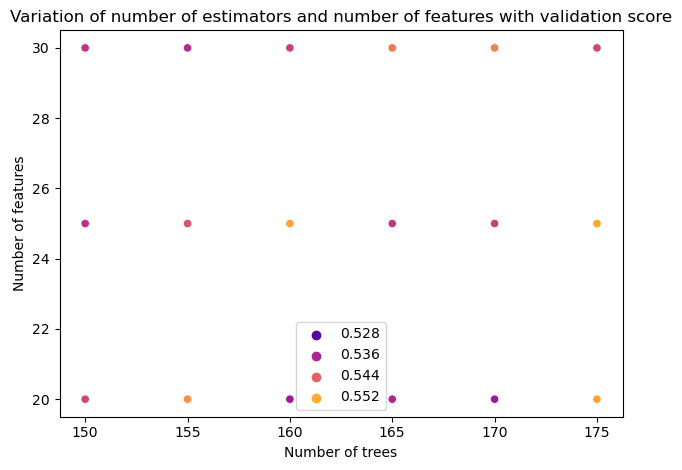

In [32]:
plt.figure()
sns.scatterplot(data=results_rf_pos,x='n_estimators_in_grid',y='max_features_in_grid',hue='Validation score',palette='plasma')
plt.title('Variation of number of estimators and number of features with validation score')
plt.legend()
plt.xlabel('Number of trees')
plt.ylabel('Number of features')
plt.tight_layout()
plt.show()

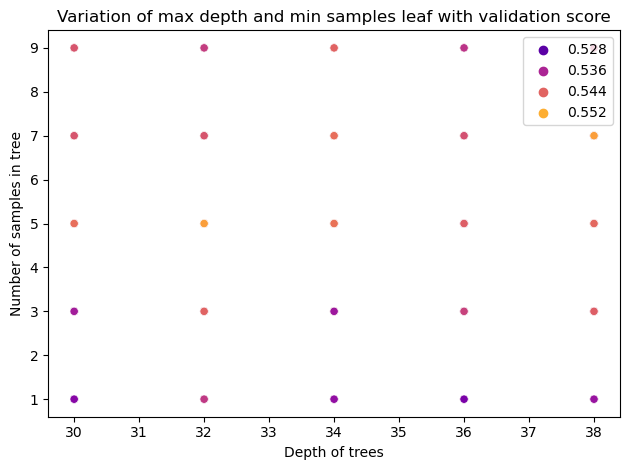

In [33]:
plt.figure()
sns.scatterplot(data=results_rf_pos,x='max_depth_in_grid',y='min_samples_leaf_in_grid',hue='Validation score',palette='plasma')
plt.title('Variation of max depth and min samples leaf with validation score')
plt.legend()
plt.xlabel('Depth of trees')
plt.ylabel('Number of samples in tree')
plt.tight_layout()
plt.show()

In [34]:
print('Best Random Forest Position model accuracy_score on X test:',fittedgrid_rf.best_estimator_.score(X_test_manual, ypos_test))

Best Random Forest Position model accuracy_score on X test: 0.576530612244898


In [35]:
# Save the best model
joblib.dump(fittedgrid_rf.best_estimator_, 'pickled_best_RF_model_pos.pkl')

['pickled_best_RF_model_pos.pkl']

In [36]:
# get confusion matrix 
y_pred=fittedgrid_rf.best_estimator_.predict(X_test_manual)
RF_confusion_matrix = confusion_matrix(ypos_test,y_pred)

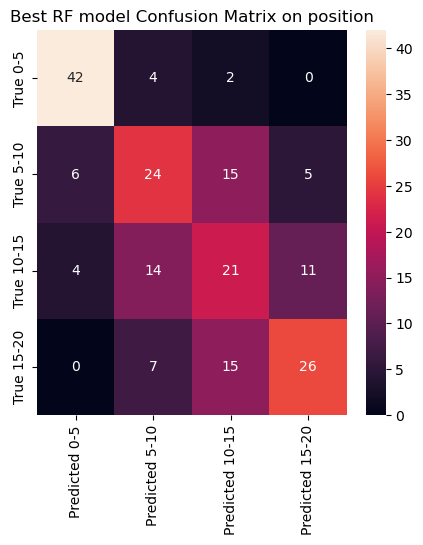

In [37]:
plt.figure(figsize=(5,5))
sns.heatmap(RF_confusion_matrix,
    xticklabels=["Predicted 0-5", "Predicted 5-10","Predicted 10-15", "Predicted 15-20" ],
    yticklabels=["True 0-5", "True 5-10","True 10-15", "True 15-20"],
 annot=True, fmt='g')
plt.title('Best RF model Confusion Matrix on position')
plt.show()

## Random Forest Lap time delta

In [38]:
param_grid_rf =[
    
    #vary DT parameters only
    {
    'random_forest__n_estimators':np.arange(10,500,10),
    'random_forest__criterion':['gini','entropy','log_loss'],
    'random_forest__max_depth':np.arange(5,100,10),
    'random_forest__min_samples_leaf': np.arange(1,50,5),
    'random_forest__max_features':[5,10,15,20,25,30,'sqrt','log2'],
    'random_forest__oob_score':[True, False],
    }
   
]

grid_rf = RandomizedSearchCV(forest_pipe, param_grid_rf, cv=5,verbose=1, n_iter=25,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_rf = grid_rf.fit(X_train_manual, ydelta_train)

print(fittedgrid_rf.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'random_forest__oob_score': True, 'random_forest__n_estimators': 360, 'random_forest__min_samples_leaf': 16, 'random_forest__max_features': 5, 'random_forest__max_depth': 15, 'random_forest__criterion': 'gini'}


In [39]:
print(fittedgrid_rf.best_params_)

{'random_forest__oob_score': True, 'random_forest__n_estimators': 360, 'random_forest__min_samples_leaf': 16, 'random_forest__max_features': 5, 'random_forest__max_depth': 15, 'random_forest__criterion': 'gini'}


In [40]:
param_grid_rf =[
    
    #vary DT parameters only
    {
    'random_forest__n_estimators':np.arange(350,400,10),
    'random_forest__criterion':['gini'],
    'random_forest__max_depth':np.arange(10,20,2),
    'random_forest__min_samples_leaf': np.arange(10,20,2),
    'random_forest__max_features':np.arange(1,15,5),
    'random_forest__oob_score':[True]    
    }
   
]

grid_rf = GridSearchCV(forest_pipe, param_grid_rf, cv=5,verbose=1,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_rf = grid_rf.fit(X_train_manual, ydelta_train)

print(fittedgrid_rf.best_params_)

Fitting 5 folds for each of 375 candidates, totalling 1875 fits
{'random_forest__criterion': 'gini', 'random_forest__max_depth': 18, 'random_forest__max_features': 1, 'random_forest__min_samples_leaf': 12, 'random_forest__n_estimators': 360, 'random_forest__oob_score': True}


In [41]:
results_rf_delta = pd.DataFrame({'Validation score':fittedgrid_rf.cv_results_['mean_test_score'],
'Train score':fittedgrid_rf.cv_results_['mean_train_score'],
'n_estimators_in_grid':fittedgrid_rf.cv_results_['param_random_forest__n_estimators'],
'max_depth_in_grid': fittedgrid_rf.cv_results_['param_random_forest__max_depth'],
'max_features_in_grid': fittedgrid_rf.cv_results_['param_random_forest__max_features'],
'min_samples_leaf_in_grid': fittedgrid_rf.cv_results_['param_random_forest__min_samples_leaf']})
results_rf_delta

,Validation score,Train score,n_estimators_in_grid,max_depth_in_grid,max_features_in_grid,min_samples_leaf_in_grid
0,0.525620,0.691877,350,10,1,10
1,0.516793,0.690702,360,10,1,10
2,0.525620,0.690995,370,10,1,10
3,0.526795,0.683932,380,10,1,10
4,0.532684,0.692614,390,10,1,10
...,...,...,...,...,...,...
370,0.508537,0.747059,350,18,11,18
371,0.512662,0.743968,360,18,11,18
372,0.514427,0.746763,370,18,11,18
373,0.515015,0.742202,380,18,11,18


In [42]:
print('Best Random Forest Lap Delta model accuracy_score on X test:',fittedgrid_rf.best_estimator_.score(X_test_manual, ydelta_test))

Best Random Forest Lap Delta model accuracy_score on X test: 0.5612244897959183


In [43]:
joblib.dump(fittedgrid_rf.best_estimator_, 'pickled_best_RF_model_delta.pkl')

['pickled_best_RF_model_delta.pkl']

In [44]:
# get confusion matrix 
y_pred=fittedgrid_rf.best_estimator_.predict(X_test_manual)
RF_confusion_matrix = confusion_matrix(ydelta_test,y_pred)

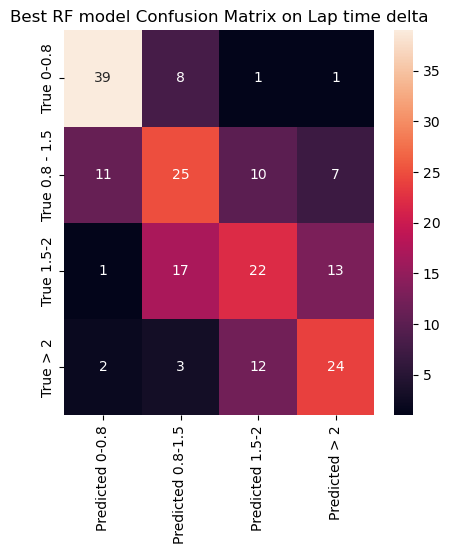

In [46]:
plt.figure(figsize=(5,5))
sns.heatmap(RF_confusion_matrix,
    xticklabels=["Predicted 0-0.8", "Predicted 0.8-1.5","Predicted 1.5-2", "Predicted > 2" ],
    yticklabels=["True 0-0.8", "True 0.8 - 1.5","True 1.5-2", "True > 2"],
 annot=True, fmt='g')
plt.title('Best RF model Confusion Matrix on Lap time delta')
plt.show()

## Feature Selection with Select from Model

## Qualifying Position

In [3]:
scale_cols, hot_encode_col = column_lists(X_train)

In [4]:
transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]
#selector = [('column_selector','passthrough',manual_features)]
random_forest_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),    
        ('select_from_model',SelectFromModel(RandomForestClassifier())),
        ('random_forest',RandomForestClassifier())# classifier
        
]
forest_pipe=Pipeline(random_forest_estimator)

In [7]:
param_grid_rf =[
    
    #vary DT parameters only
    {
    'select_from_model__threshold' : ['1.75*mean'],
    'random_forest__n_estimators':np.arange(350,400,10),
    'random_forest__criterion':['gini'],
    'random_forest__max_depth':np.arange(10,20,2),
    'random_forest__min_samples_leaf': np.arange(10,20,2),
    'random_forest__max_features':np.arange(1,15,5),
    'random_forest__oob_score':[True]    
    }
   
]

grid_rf = GridSearchCV(forest_pipe, param_grid_rf, cv=5,verbose=1,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_rf = grid_rf.fit(X_train, ypos_train)

print(fittedgrid_rf.best_params_)

Fitting 5 folds for each of 375 candidates, totalling 1875 fits
{'random_forest__criterion': 'gini', 'random_forest__max_depth': 12, 'random_forest__max_features': 11, 'random_forest__min_samples_leaf': 16, 'random_forest__n_estimators': 370, 'random_forest__oob_score': True, 'select_from_model__threshold': '1.75*mean'}


In [8]:
print('Best Random Forest Position model accuracy_score on X test:',fittedgrid_rf.best_estimator_.score(X_test, ypos_test))

Best Random Forest Position model accuracy_score on X test: 0.576530612244898


In [9]:
# get confusion matrix 
y_pred=fittedgrid_rf.best_estimator_.predict(X_test)
RF_confusion_matrix = confusion_matrix(ypos_test,y_pred)

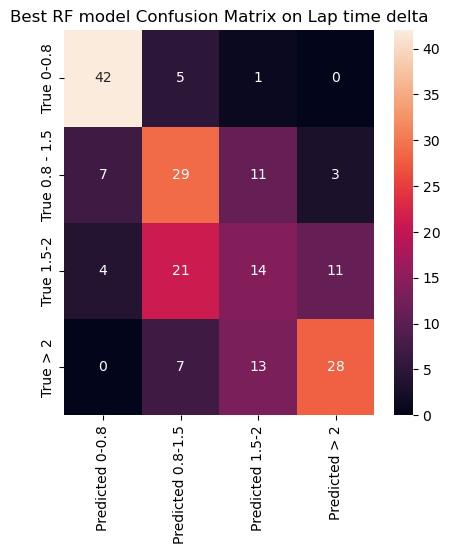

In [10]:
plt.figure(figsize=(5,5))
sns.heatmap(RF_confusion_matrix,
    xticklabels=["Predicted 0-0.8", "Predicted 0.8-1.5","Predicted 1.5-2", "Predicted > 2" ],
    yticklabels=["True 0-0.8", "True 0.8 - 1.5","True 1.5-2", "True > 2"],
 annot=True, fmt='g')
plt.title('Best RF model Confusion Matrix on Lap time delta')
plt.show()

## Lap time delta 

### Selection via Select from model

In [11]:
param_grid_rf =[
    
    #vary DT parameters only
    {
    'select_from_model__threshold' : ['1.75*mean'],
    'random_forest__n_estimators':np.arange(350,400,10),
    'random_forest__criterion':['gini'],
    'random_forest__max_depth':np.arange(10,20,2),
    'random_forest__min_samples_leaf': np.arange(10,20,2),
    'random_forest__max_features':np.arange(1,15,5),
    'random_forest__oob_score':[True]    
    }
   
]

grid_rf = GridSearchCV(forest_pipe, param_grid_rf, cv=5,verbose=1,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_rf = grid_rf.fit(X_train, ydelta_train)

print(fittedgrid_rf.best_params_)

Fitting 5 folds for each of 375 candidates, totalling 1875 fits
{'random_forest__criterion': 'gini', 'random_forest__max_depth': 18, 'random_forest__max_features': 11, 'random_forest__min_samples_leaf': 18, 'random_forest__n_estimators': 390, 'random_forest__oob_score': True, 'select_from_model__threshold': '1.75*mean'}


In [15]:
print('Best Random Forest lap delta model accuracy_score on X test:',fittedgrid_rf.best_estimator_.score(X_test, ypos_test))

Best Random Forest lap delta model accuracy_score on X test: 0.5459183673469388


In [13]:
# get confusion matrix 
y_pred=fittedgrid_rf.best_estimator_.predict(X_test)
RF_confusion_matrix = confusion_matrix(ydelta_test,y_pred)

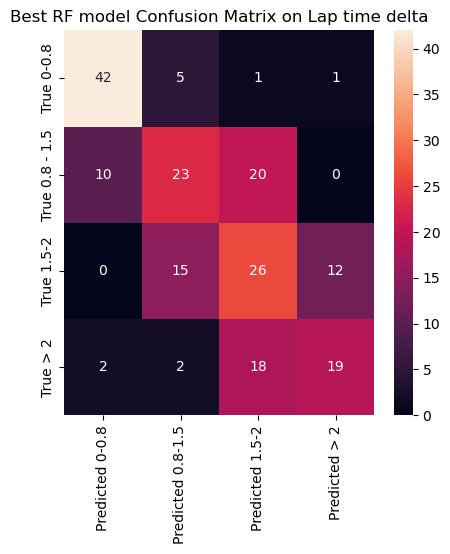

In [14]:
plt.figure(figsize=(5,5))
sns.heatmap(RF_confusion_matrix,
    xticklabels=["Predicted 0-0.8", "Predicted 0.8-1.5","Predicted 1.5-2", "Predicted > 2" ],
    yticklabels=["True 0-0.8", "True 0.8 - 1.5","True 1.5-2", "True > 2"],
 annot=True, fmt='g')
plt.title('Best RF model Confusion Matrix on Lap time delta')
plt.show()